In [1]:
from __future__ import absolute_import, division, print_function

import sys
import os
import time
from math import ceil, floor, sqrt

sys.path.insert(0,'../../')
sys.path.insert(0,'../../../py')

import parameters
import utilities
import output_utilities
from spectrogram_utilities import spectrogram_plot, spectrogram_reshape
from spectrogram_output_visualiser import spectrogram_and_output, spectrogram_cut
import spectrogram_cuts_db_creation


import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt

import tensorflow as tf
import keras

# matplotlib.get_backend()
%matplotlib inline

# constants
awd_event = 1
site = parameters.sites[0]

(500, 500) (128, 128)


In [2]:
from sklearn import preprocessing
data = np.arange(parameters.clf_input_height*parameters.clf_input_width).reshape(1,parameters.clf_input_height*parameters.clf_input_width)
evt = np.arange(1)
# load dataset from every site
for site in parameters.sites:
    _data, pb, _evt, f_cut_length, t_cut_length = spectrogram_cuts_db_creation.load_spectrogram_cuts_db(awd_event, site, 'training_set_'+site+'.h5', verbose=True, noise=True)
    print(_data.shape, _evt.shape)
    data = np.append(data,_data, axis=0)
    evt = np.append(evt,_evt, axis=0)
# remove first element
data = np.delete(data, 0, 0)
evt = np.delete(evt, 0, 0)
# shuffle 
data = list(zip(data,evt))
np.random.shuffle(data)
data, evt = zip(*data)
data = np.array(data)
evt = np.array(evt)
print(data.shape, evt.shape)
scaler = preprocessing.StandardScaler().fit(data)


Loading spectrogram cuts from database for awdEvent1/marion
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........
Runtime: 21.63 seconds
(19804, 16384) (19804,)

Loading spectrogram cuts from database for awdEvent1/sanae
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........
Runtime: 2.60 seconds
(2289, 16384) (2289,)
(22093, 16384) (22093,)


2013-07-25UT05:24:35.84611922.marion.vr2


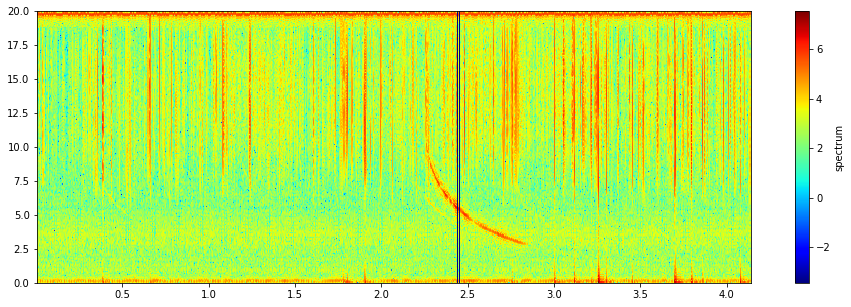

(257, 863)
4 3


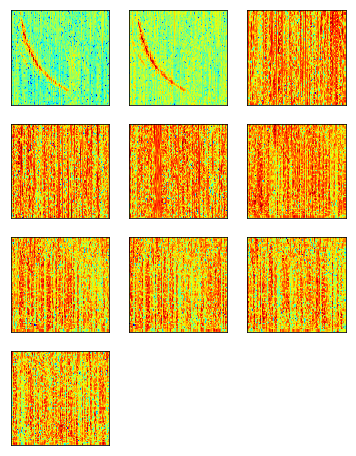

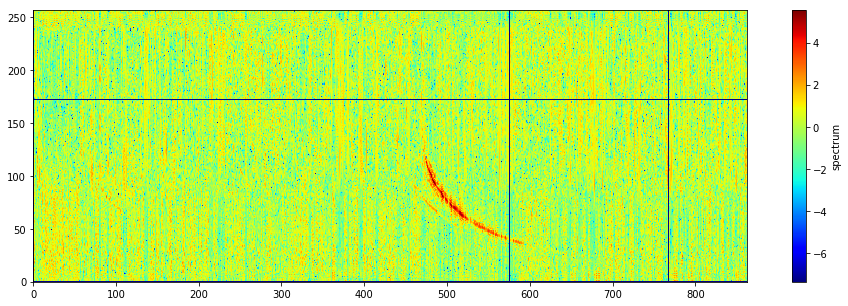

TypeError: 'float' object cannot be interpreted as an integer

In [7]:
# get file
site = parameters.sites[0]
file = utilities.random_file(awd_event, site)
# file = '2013-08-14UT21:11:41.44611906.marion.vr2'
file = '2013-07-25UT05:24:35.84611922.marion.vr2'
print(file)
_, time, freq, spec = spectrogram_and_output(awd_event, site, file, output=True, zscore=False)
_ = spectrogram_plot(spec,x_axis=time, y_axis=freq/1000, size=(16,5))
_, time, freq, spec = spectrogram_and_output(awd_event, site, file, output=False, zscore=True)


# CUTS FROM CLASSIFIER
indices, spectrogram, specs_cuts, noise_cuts, f_cut_length, t_cut_length = spectrogram_cut(
    awd_event, site, file, threshold=10, zscore=True, output=False,
    time_lower_boundary = 0.3,
    time_upper_boundary = 0.9,
    freq_upper_boundary = 10000,
    freq_lower_boundary = 1500)
print(spectrogram.shape)

if specs_cuts.size!=0 and noise_cuts.size!=0:
    cuts = np.append(specs_cuts, noise_cuts, axis=0)
elif specs_cuts.size==0:
    cuts = noise_cuts
elif noise_cuts.size==0:
    cuts=specs_cuts
else:
    cuts = np.array([], dtype=float64)
    
x_size = ceil(sqrt(len(cuts)))
y_size = ceil(len(cuts)/x_size)
print(x_size, y_size)

plt.figure(figsize=(y_size*2,x_size*2))
for i in range(len(cuts)):
    plt.subplot(x_size, y_size,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    _spec = spectrogram[cuts[i][0]:cuts[i][1],cuts[i][2]:cuts[i][3]]
#     spec = Image.fromarray(spec).resize((parameters.clf_input_height,parameters.clf_input_width))
#     spec = np.array(spec)
    _spec = spectrogram_reshape(_spec)
    plt.pcolormesh(_spec, cmap='jet')
plt.show()



heigth = 1
width = 3*heigth
_spec = spec.copy()
f_max, t_max = spec.shape
t_index = np.array(list(range(0, t_max, ceil(t_max/width))))
f_index = np.array(list(range(0, f_max, ceil(f_max/heigth))))
for t in t_index:
#     print(t)
    _spec[:,t] = np.full(spec[:,0].shape, spec.min())
for f in f_index:
    _spec[f,:] = np.full(spec[0,:].shape, spec.min())
#         print((t,f), (t+int(t_max/S),f+int(f_max/S)))
_ = spectrogram_plot(_spec, size=(16,5))
# print((t_max,f_max))
# print(t_index)
# print(f_index)

# load neural network
model = keras.models.load_model('3_layers.h5')

cuts = []
pred_cuts = []
result = []
for t in range(len(t_index)):
    for f in range(len(f_index)):
        # get cut coordinate
        cut = []
        if t < len(t_index)-1 and f<len(f_index)-1:
            cut = [f_index[f],f_index[f+1],t_index[t],t_index[t+1]]
        elif f == len(f_index)-1 and t < len(t_index)-1:
            cut = [f_index[f],f_max,t_index[t],t_index[t+1]]
        elif t==len(t_index)-1 and f < len(f_index)-1:
            cut = [f_index[f],f_index[f+1],t_index[t],t_max]
        else:
            cut = [f_index[f],f_max,t_index[t],t_max]

        spec_cut = _spec[cut[0]:cut[1], cut[2]:cut[3]]
        spec_cut = spectrogram_reshape(spec_cut).flatten().reshape(1,parameters.clf_input_width*parameters.clf_input_height)
        spec_cut = scaler.transform(spec_cut)
        pred = model.predict(spec_cut)
        pred = np.argmax(pred, axis=1)

        
        cuts.append(cut)
        pred_cuts.append(pred)
        
        result.append([cut,pred])
        
pred_cuts = np.array(pred_cuts).reshape(heigth,width)
result = np.array(result)
print(result)